In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

## Modeling

In [3]:
import pandas as pd
from utils.utils import set_seed

set_seed()

### Load data

In [4]:
ds_train = pd.read_csv("../data/avila/avila-tr.txt", header=None)
ds_test = pd.read_csv("../data/avila/avila-ts.txt", header=None)

### Models

In [5]:
# -- Required models --

# KNN
from sklearn.neighbors import KNeighborsClassifier

# LVQ
from sklvq import GLVQ

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# SVM
from sklearn.svm import SVC

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# MLP
from sklearn.neural_network import MLPClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier, BaggingClassifier

# -- Optional models --

# XGBoost
from xgboost import XGBClassifier

In [6]:
# -- Auxiliar functions --

from time import time


# Compute Training Time
class Timer:
    def __init__(self):
        self.start = time()

    def __call__(self):
        return time() - self.start

### Training

In [7]:
# Metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# import label encoder
from sklearn.preprocessing import LabelEncoder


def get_model_name(model):
    if model.__class__.__name__ == "VotingClassifier":
        return (
            model.__class__.__name__
            + "_"
            + "_".join([estimator[0] for estimator in model.estimators])
        )
    return model.__class__.__name__


# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=1),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=1),
        "f1": f1_score(y_true, y_pred, average="macro", zero_division=1),
    }


# Split data
X_train = ds_train.iloc[:, :-1]
y_train = ds_train.iloc[:, -1]
X_test = ds_test.iloc[:, :-1]
y_test = ds_test.iloc[:, -1]

label_encoder = LabelEncoder().fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

#### Training - Baseline

In [ ]:
%%time

# Best models of a pre-run are chosen to ensemble
models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    VotingClassifier(
        estimators=[
            ("dt", DecisionTreeClassifier()),
            ("knn", KNeighborsClassifier()),
            ("rf", RandomForestClassifier()),
        ],
        voting="hard",
    ),
    VotingClassifier(
        estimators=[
            ("mlp1", MLPClassifier()),
            ("mlp2", MLPClassifier()),
            ("mlp3", MLPClassifier()),
        ],
        voting="hard",
    ),
]

models_results = {get_model_name(model): {} for model in models}

for model in models:
    print("Training model: ", get_model_name(model))

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()

    # add new name to dataframe
    models_results[get_model_name(model)] = metrics

In [ ]:
models_results = pd.DataFrame(models_results).T.dropna()
models_results

In [8]:
%%time

# Best models of a pre-run are chosen to ensemble
models = [
    KNeighborsClassifier(
        n_neighbors=16, weights="distance", metric="manhattan", n_jobs=-1
    ),
    GLVQ(
        activation_type="swish",
        distance_type="squared-euclidean",
        prototype_n_per_class=83,
    ),
    SVC(C=172.60, kernel="sigmoid", degree=3),
    DecisionTreeClassifier(
        criterion="entropy",
        splitter="best",
        max_depth=16,
        min_samples_split=17,
        min_samples_leaf=6,
    ),
    RandomForestClassifier(
        n_estimators=15,
        criterion="gini",
        max_depth=20,
        min_samples_leaf=5,
        min_samples_split=34,
    ),
    XGBClassifier(max_depth=38, learning_rate=241.99, n_estimators=14, gamma=6.20),
    MLPClassifier(
        activation="tanh",
        solver="adam",
        hidden_layer_sizes=[100] * 7,
        learning_rate="adaptive",
        learning_rate_init=0.00035547,
    ),
    VotingClassifier(
        estimators=[
            (
                "dt",
                DecisionTreeClassifier(
                    criterion="entropy",
                    splitter="best",
                    max_depth=16,
                    min_samples_split=17,
                    min_samples_leaf=6,
                ),
            ),
            (
                "knn",
                KNeighborsClassifier(
                    n_neighbors=16, weights="distance", metric="manhattan", n_jobs=-1
                ),
            ),
            (
                "rf",
                RandomForestClassifier(
                    n_estimators=15,
                    criterion="gini",
                    max_depth=20,
                    min_samples_leaf=5,
                    min_samples_split=34,
                ),
            ),
        ],
        voting="hard",
    ),
    VotingClassifier(
        estimators=[
            (
                "mlp1",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
            (
                "mlp2",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
            (
                "mlp3",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
        ],
        voting="hard",
    ),
]


models_results = {get_model_name(model): {} for model in models}

for model in models:
    print("Training model: ", get_model_name(model))

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()

    # add new name to dataframe
    models_results[get_model_name(model)] = metrics

Training model:  KNeighborsClassifier
Training model:  GLVQ
Training model:  SVC
Training model:  DecisionTreeClassifier
Training model:  RandomForestClassifier
Training model:  XGBClassifier
Training model:  MLPClassifier
Training model:  VotingClassifier_dt_knn_rf
Training model:  VotingClassifier_mlp1_mlp2_mlp3
CPU times: total: 16min 16s
Wall time: 11min 16s


In [9]:
_models_results = pd.DataFrame(models_results).T.dropna()
_models_results

,accuracy,precision,recall,f1,fit_time
KNeighborsClassifier,0.814027,0.890812,0.733634,0.790114,0.663026
GLVQ,0.670308,0.535439,0.538546,0.498649,549.905414
SVC,0.417840,0.246153,0.207907,0.216263,4.392346
DecisionTreeClassifier,0.961387,0.921012,0.856274,0.845889,0.090996
RandomForestClassifier,0.909648,0.949339,0.763796,0.803535,0.266000
XGBClassifier,0.943758,0.956034,0.858199,0.865184,0.605325
MLPClassifier,0.979496,0.984787,0.974119,0.979298,32.258904
VotingClassifier_dt_knn_rf,0.926320,0.960128,0.820713,0.871426,1.026975
VotingClassifier_mlp1_mlp2_mlp3,0.983616,0.985116,0.979032,0.982041,86.839789


### Decition Tree View

Use [GraphViz Render](https://dreampuf.github.io/GraphvizOnline/#digraph%20G%20%7B%0A%0A%20%20subgraph%20cluster_0%20%7B%0A%20%20%20%20style%3Dfilled%3B%0A%20%20%20%20color%3Dlightgrey%3B%0A%20%20%20%20node%20%5Bstyle%3Dfilled%2Ccolor%3Dwhite%5D%3B%0A%20%20%20%20a0%20-%3E%20a1%20-%3E%20a2%20-%3E%20a3%3B%0A%20%20%20%20label%20%3D%20%22process%20%231%22%3B%0A%20%20%7D%0A%0A%20%20subgraph%20cluster_1%20%7B%0A%20%20%20%20node%20%5Bstyle%3Dfilled%5D%3B%0A%20%20%20%20b0%20-%3E%20b1%20-%3E%20b2%20-%3E%20b3%3B%0A%20%20%20%20label%20%3D%20%22process%20%232%22%3B%0A%20%20%20%20color%3Dblue%0A%20%20%7D%0A%20%20start%20-%3E%20a0%3B%0A%20%20start%20-%3E%20b0%3B%0A%20%20a1%20-%3E%20b3%3B%0A%20%20b2%20-%3E%20a3%3B%0A%20%20a3%20-%3E%20a0%3B%0A%20%20a3%20-%3E%20end%3B%0A%20%20b3%20-%3E%20end%3B%0A%0A%20%20start%20%5Bshape%3DMdiamond%5D%3B%0A%20%20end%20%5Bshape%3DMsquare%5D%3B%0A%7D) to render

In [25]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(
    models[3],
    out_file=None,
    feature_names=X_train.columns,  # Substitua pelo nome das suas features
    class_names=label_encoder.classes_,  # Substitua pelo nome das suas classes
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=4,
)

# Use GraphViz Online to Render
graph = graphviz.Source(dot_data)
graph.save("tree.gv")

### Stratified KFold

In [30]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder


def stratified_cross_val(model_list, data, n_folds=30, n_splits=10):
    model_results = {get_model_name(model): [] for model in model_list}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    X = data.iloc[:, :-1]
    y = LabelEncoder().fit_transform(data.iloc[:, -1])

    for model in model_list:
        pipeline = Pipeline(
            [
                # ("scaler", StandardScaler()), # uncomment to scale data
                ("model", model)
            ]
        )

        for _ in range(n_folds):
            iter_scores = cross_validate(
                pipeline,
                X,
                y,
                cv=cv,
                scoring={
                    "f1_score": "f1_macro",
                    "precision_score": "precision_macro",
                    "accuracy_score": "accuracy",
                    "recall_score": "recall_macro",
                },
                n_jobs=-1,
            )
            model_results[get_model_name(model)].append(iter_scores)

    return model_results


def model_results_to_df(model_results):
    res_final = pd.DataFrame(
        columns=[
            "fit_time",
            "score_time",
            "test_f1_score",
            "test_precision_score",
            "test_accuracy_score",
            "test_recall_score",
            "split",
            "model",
        ]
    )

    for model in model_results.keys():
        for i in range(len(model_results[model])):
            _res = pd.DataFrame(
                model_results[model][i].values(),
                index=model_results[model][i].keys(),
            ).T
            _res["split"] = i
            _res["model"] = model
            res_final = pd.concat([res_final, _res])

    return res_final

In [31]:
models = [
    KNeighborsClassifier(
        n_neighbors=16, weights="distance", metric="manhattan", n_jobs=-1
    ),
    GLVQ(
        activation_type="swish",
        distance_type="squared-euclidean",
        prototype_n_per_class=83,
    ),
    SVC(C=172.60, kernel="sigmoid", degree=3),
    DecisionTreeClassifier(
        criterion="entropy",
        splitter="best",
        max_depth=16,
        min_samples_split=17,
        min_samples_leaf=6,
    ),
    RandomForestClassifier(
        n_estimators=15,
        criterion="gini",
        max_depth=20,
        min_samples_leaf=5,
        min_samples_split=34,
    ),
    XGBClassifier(max_depth=38, learning_rate=241.99, n_estimators=14, gamma=6.20),
    MLPClassifier(
        activation="tanh",
        solver="adam",
        hidden_layer_sizes=[100] * 7,
        learning_rate="adaptive",
        learning_rate_init=0.00035547,
    ),
    VotingClassifier(
        estimators=[
            (
                "dt",
                DecisionTreeClassifier(
                    criterion="entropy",
                    splitter="best",
                    max_depth=16,
                    min_samples_split=17,
                    min_samples_leaf=6,
                ),
            ),
            (
                "knn",
                KNeighborsClassifier(
                    n_neighbors=16, weights="distance", metric="manhattan", n_jobs=-1
                ),
            ),
            (
                "rf",
                RandomForestClassifier(
                    n_estimators=15,
                    criterion="gini",
                    max_depth=20,
                    min_samples_leaf=5,
                    min_samples_split=34,
                ),
            ),
        ],
        voting="hard",
    ),
    VotingClassifier(
        estimators=[
            (
                "mlp1",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
            (
                "mlp2",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
            (
                "mlp3",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
        ],
        voting="hard",
    ),
]

stratified_crossval_results = model_results_to_df(
    stratified_cross_val(models, ds_train, n_folds=10, n_splits=5)
)

stratified_crossval_results.head().style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score,split,model
0,0.020998,0.375000,0.765281,0.893192,0.811122,0.711658,0,KNeighborsClassifier
1,0.016994,0.249002,0.737363,0.872992,0.781400,0.675307,0,KNeighborsClassifier
2,0.020997,0.325001,0.763474,0.849871,0.788591,0.712280,0,KNeighborsClassifier
3,0.016994,0.184001,0.718684,0.849729,0.777565,0.660831,0,KNeighborsClassifier
4,0.017997,0.278002,0.742660,0.878773,0.792905,0.690012,0,KNeighborsClassifier


### Metrics

In [32]:
stratified_crossval_results.groupby("model").mean(numeric_only=True).style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
DecisionTreeClassifier,0.083554,0.007460,0.837341,0.854148,0.955513,0.830003
GLVQ,571.592071,0.126196,0.477197,0.513917,0.653154,0.530024
KNeighborsClassifier,0.017477,0.335494,0.748579,0.869105,0.789406,0.691987
MLPClassifier,46.622298,0.027522,0.962198,0.964134,0.967680,0.961606
RandomForestClassifier,0.245975,0.013952,0.735590,0.832396,0.877728,0.689596
SVC,1.859970,0.491191,0.226824,0.256944,0.436433,0.218679
VotingClassifier_dt_knn_rf,0.338937,0.373301,0.839266,0.919253,0.912867,0.795069
VotingClassifier_mlp1_mlp2_mlp3,126.219531,0.073494,0.972178,0.974260,0.975944,0.971822
XGBClassifier,1.381368,0.026354,0.837921,0.855888,0.922483,0.823757


In [33]:
stratified_crossval_results.groupby("model").std(numeric_only=True).style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
DecisionTreeClassifier,0.006018,0.001473,0.018708,0.019511,0.006851,0.025775
GLVQ,133.350949,0.027595,0.010612,0.019126,0.008253,0.011240
KNeighborsClassifier,0.002887,0.101952,0.016158,0.017364,0.009240,0.016780
MLPClassifier,5.725731,0.006971,0.018539,0.019565,0.006737,0.018494
RandomForestClassifier,0.015710,0.001960,0.022565,0.025608,0.011380,0.021389
SVC,0.174083,0.033493,0.023672,0.028047,0.024553,0.019301
VotingClassifier_dt_knn_rf,0.029236,0.077614,0.047183,0.042692,0.008548,0.048962
VotingClassifier_mlp1_mlp2_mlp3,5.889080,0.016015,0.008927,0.011917,0.004808,0.007329
XGBClassifier,0.328005,0.008065,0.017534,0.015183,0.009709,0.021718


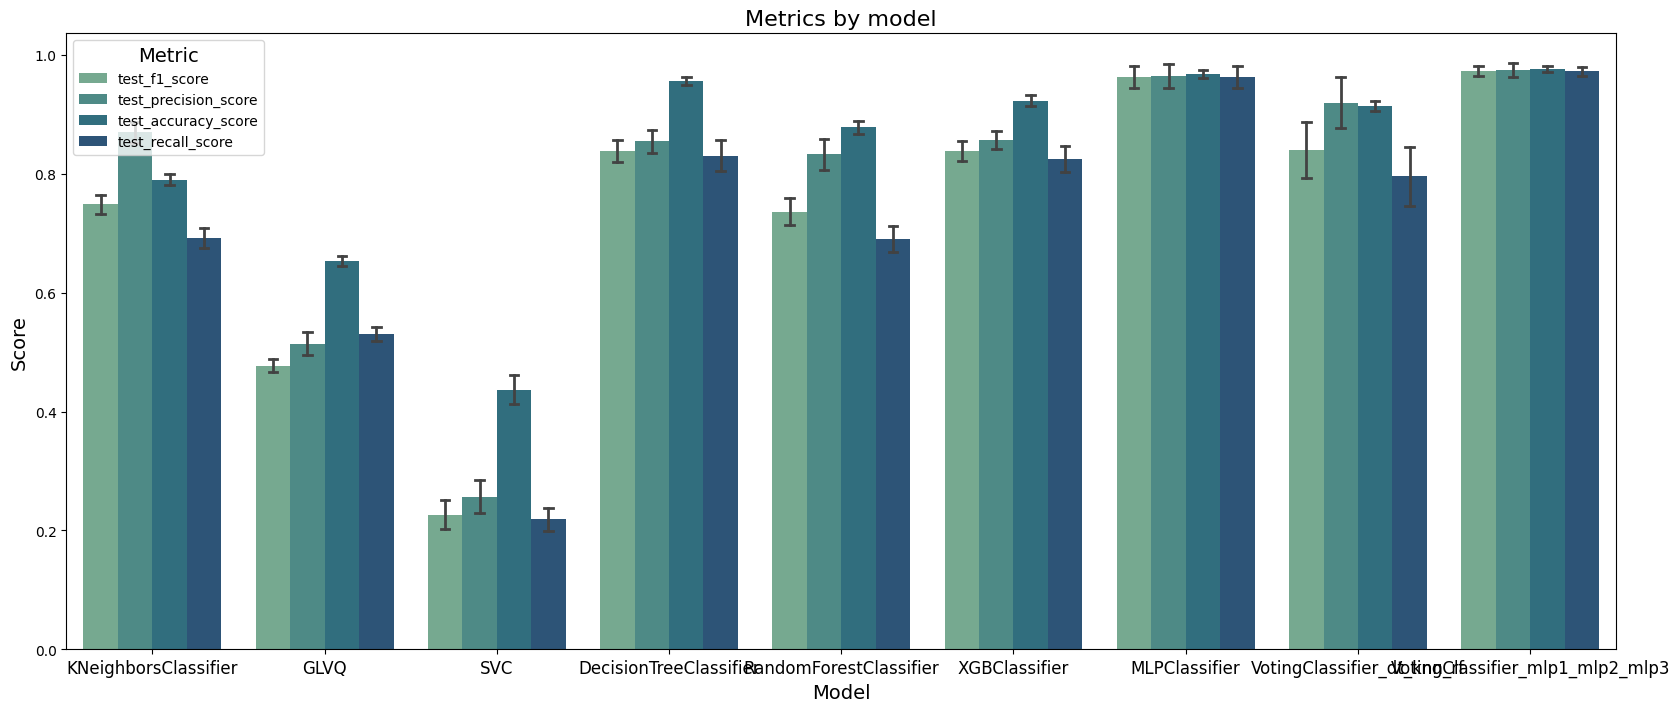

In [34]:
# Plot metrics average with confidence intervals

import matplotlib.pyplot as plt
import seaborn as sns

results_long = stratified_crossval_results.melt(
    id_vars=["split", "model"],
    value_vars=[
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ],
    var_name="metric",
    value_name="score",
)

plt.figure(figsize=(20, 8))
sns.barplot(
    data=results_long,
    x="model",
    y="score",
    hue="metric",
    errorbar="sd",
    errwidth=2,
    capsize=0.05,
    palette="crest",
)
plt.title("Metrics by model", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.legend(title="Metric", title_fontsize="14", loc="upper left")
plt.show()

### Friedman and Nemeyni Tests

In [35]:
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman


def perform_friedman_nemenyi_tests(df):
    metrics = [
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ]
    models = df["model"].unique()
    folds = df["split"].unique()

    results = {}
    for metric in metrics:
        results[metric] = np.zeros((len(models), len(folds)))
        for i, model in enumerate(models):
            for j, fold in enumerate(folds):
                results[metric][i, j] = df.loc[
                    (df["model"] == model) & (df["split"] == fold)
                ][metric].values[0]

    # Friedman test
    for metric in metrics:
        stat, p_value = friedmanchisquare(*results[metric])
        print(f"{metric}: Friedman Chi Square = {stat:.3f}, p-value = {p_value:.3f}")
        if p_value < 0.05:
            print("Significant difference between models\n")
        else:
            print("No significant difference between models")

    # Nemenyi test
    for metric in metrics:
        posthoc = posthoc_nemenyi_friedman(results[metric].T)
        print(f"\nNemenyi PostHoc Test for {metric}:")
        print(posthoc)


perform_friedman_nemenyi_tests(stratified_crossval_results)

test_f1_score: Friedman Chi Square = 75.253, p-value = 0.000
Significant difference between models

test_precision_score: Friedman Chi Square = 71.600, p-value = 0.000
Significant difference between models

test_accuracy_score: Friedman Chi Square = 79.246, p-value = 0.000
Significant difference between models

test_recall_score: Friedman Chi Square = 76.427, p-value = 0.000
Significant difference between models


Nemenyi PostHoc Test for test_f1_score:
          0         1         2         3         4         5         6   
0  1.000000  0.809296  0.301968  0.809296  0.900000  0.660658  0.013263  \
1  0.809296  1.000000  0.900000  0.049862  0.900000  0.023112  0.001000   
2  0.301968  0.900000  1.000000  0.002867  0.611110  0.001042  0.001000   
3  0.809296  0.049862  0.002867  1.000000  0.512019  0.900000  0.561564   
4  0.900000  0.900000  0.611110  0.512019  1.000000  0.351152  0.002063   
5  0.660658  0.023112  0.001042  0.900000  0.351152  1.000000  0.710204   
6  0.013263  0.00

### Box-Plot Analysis

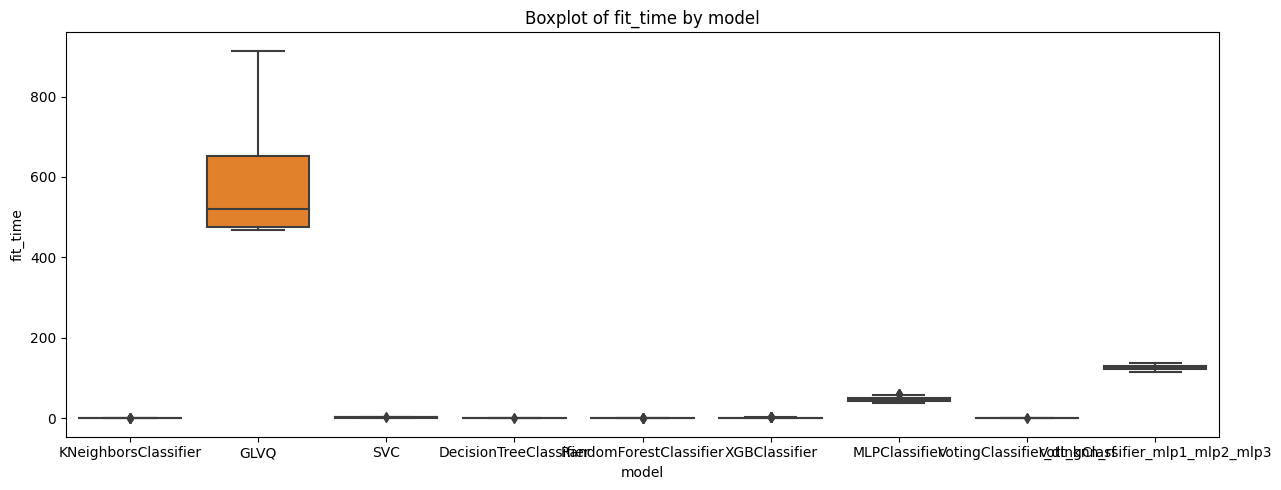

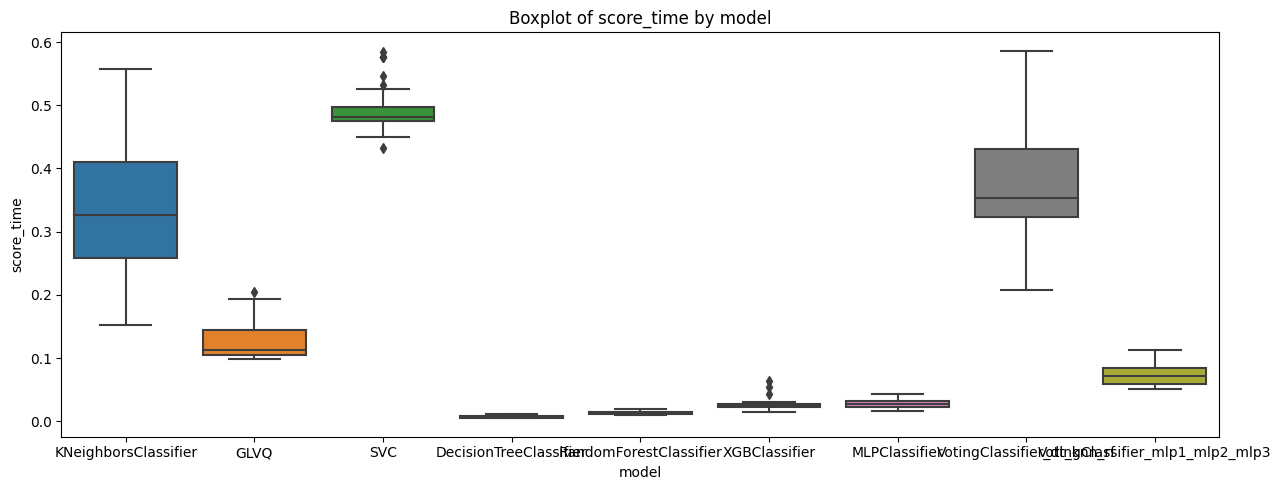

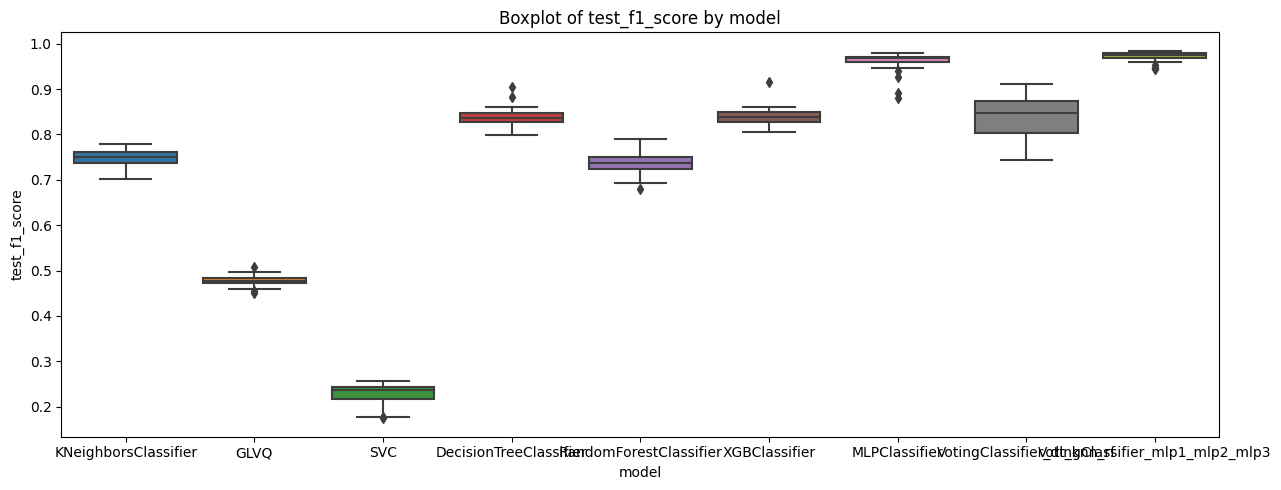

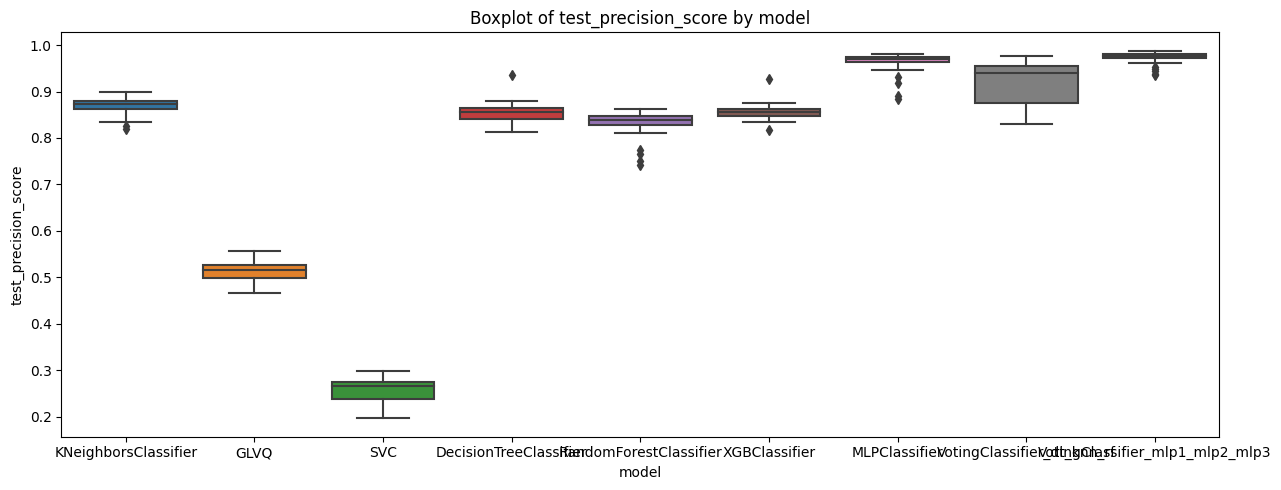

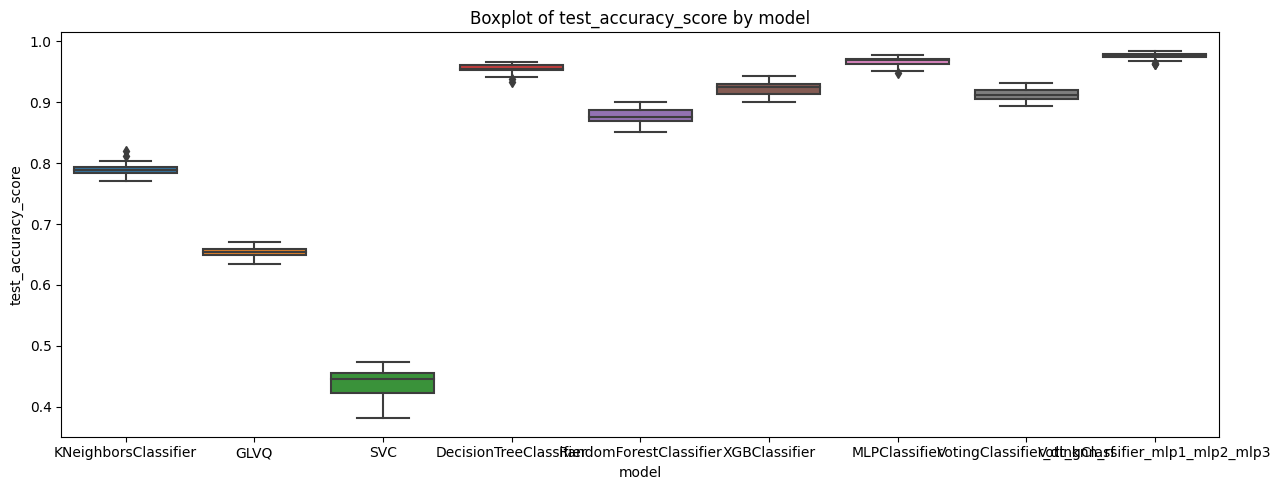

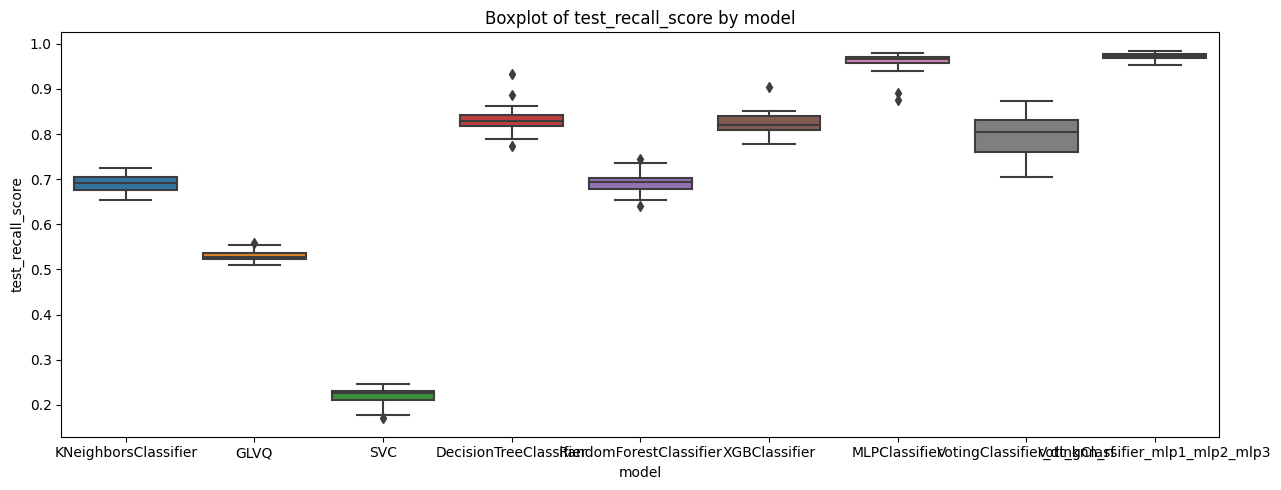

In [36]:
# Analyse models with boxplots

# metrics to be analyzed
metrics = [
    "fit_time",
    "score_time",
    "test_f1_score",
    "test_precision_score",
    "test_accuracy_score",
    "test_recall_score",
]

# create a separate plot for each metric
for metric in metrics:
    plt.figure(figsize=(13, 5))
    sns.boxplot(x="model", y=metric, data=stratified_crossval_results)
    plt.title(f"Boxplot of {metric} by model")
    plt.xticks()  # rotate x-axis labels
    plt.tight_layout()
    plt.show()

### Confusion Matrix

In [37]:
# Fit models for comparison (when hyperparameters are tunned, pass tunning params to the model)

models = [
    KNeighborsClassifier(
        n_neighbors=16, weights="distance", metric="manhattan", n_jobs=-1
    ),
    GLVQ(
        activation_type="swish",
        distance_type="squared-euclidean",
        prototype_n_per_class=83,
    ),
    SVC(C=172.60, kernel="sigmoid", degree=3),
    DecisionTreeClassifier(
        criterion="entropy",
        splitter="best",
        max_depth=16,
        min_samples_split=17,
        min_samples_leaf=6,
    ),
    RandomForestClassifier(
        n_estimators=15,
        criterion="gini",
        max_depth=20,
        min_samples_leaf=5,
        min_samples_split=34,
    ),
    XGBClassifier(max_depth=38, learning_rate=241.99, n_estimators=14, gamma=6.20),
    MLPClassifier(
        activation="tanh",
        solver="adam",
        hidden_layer_sizes=[100] * 7,
        learning_rate="adaptive",
        learning_rate_init=0.00035547,
    ),
    VotingClassifier(
        estimators=[
            (
                "dt",
                DecisionTreeClassifier(
                    criterion="entropy",
                    splitter="best",
                    max_depth=16,
                    min_samples_split=17,
                    min_samples_leaf=6,
                ),
            ),
            (
                "knn",
                KNeighborsClassifier(
                    n_neighbors=16, weights="distance", metric="manhattan", n_jobs=-1
                ),
            ),
            (
                "rf",
                RandomForestClassifier(
                    n_estimators=15,
                    criterion="gini",
                    max_depth=20,
                    min_samples_leaf=5,
                    min_samples_split=34,
                ),
            ),
        ],
        voting="hard",
    ),
    VotingClassifier(
        estimators=[
            (
                "mlp1",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
            (
                "mlp2",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
            (
                "mlp3",
                MLPClassifier(
                    activation="tanh",
                    solver="adam",
                    hidden_layer_sizes=[100] * 7,
                    learning_rate="adaptive",
                    learning_rate_init=0.00035547,
                ),
            ),
        ],
        voting="hard",
    ),
]

models_results = {get_model_name(model): {} for model in models}

for model in models:
    print("Training model: ", get_model_name(model))

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()
    models_results[get_model_name(model)] = metrics

Training model:  KNeighborsClassifier
Training model:  GLVQ
Training model:  SVC
Training model:  DecisionTreeClassifier
Training model:  RandomForestClassifier
Training model:  XGBClassifier
Training model:  MLPClassifier
Training model:  VotingClassifier_dt_knn_rf
Training model:  VotingClassifier_mlp1_mlp2_mlp3


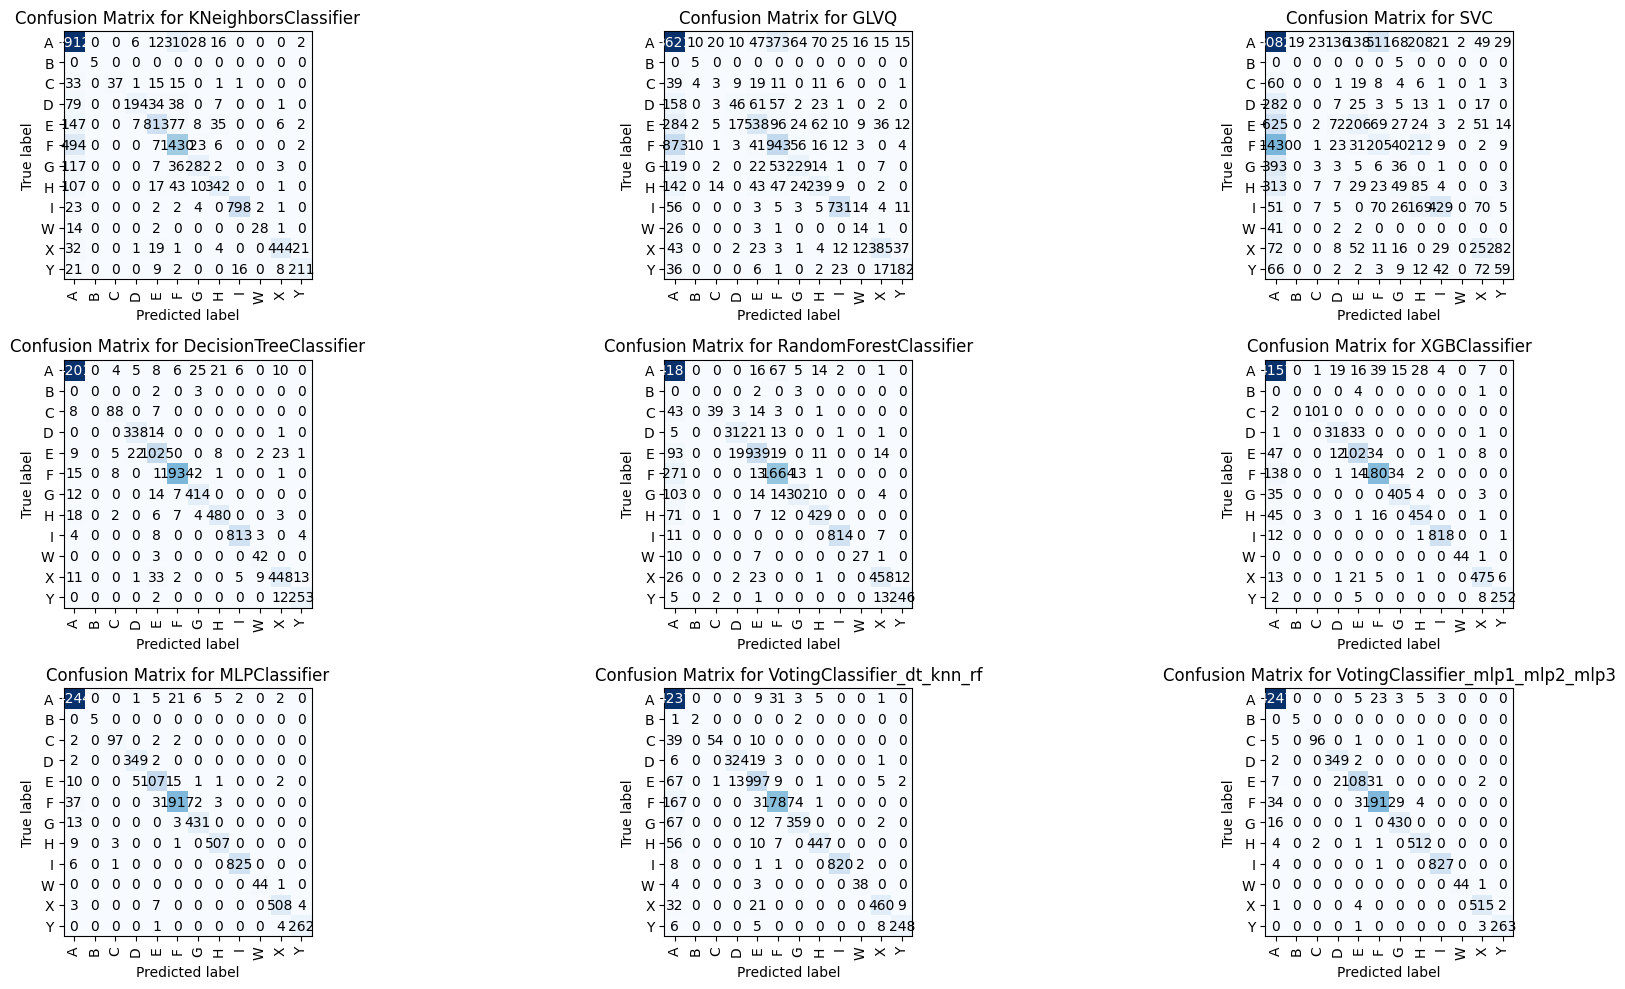

In [40]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X_test, y_test, normalize=None, ax=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize=normalize)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(cm, cmap=plt.cm.Blues)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize == "true":
                text = f"{cm[i, j]:.2f}"
            else:
                text = str(cm[i, j])
            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black",
            )

    # fig.delaxes(axs[-1, -1])

    ax.set_xticks(range(len(label_encoder.classes_)))
    ax.set_xticklabels(label_encoder.classes_, rotation=90)
    ax.set_yticks(range(len(label_encoder.classes_)))
    ax.set_yticklabels(label_encoder.classes_)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix for {get_model_name(model)}")
    return ax


fig, axes = plt.subplots(3, 3, figsize=(20, 10))
for i, model in enumerate(models):
    plot_confusion_matrix(model, X_test, y_test, ax=axes[i // 3, i % 3])
plt.tight_layout()

### Tuning

In [ ]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
import os

# Avoid use n_jobs=-1 in each call of sklearn model
os.environ["JOBLIB_MULTIPROCESSING"] = "true"


def objective(trial, model_name, data):
    X_train, X_test, y_train, y_test = data

    if model_name == "KNeighborsClassifier":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        metric = trial.suggest_categorical("metric", ["euclidean", "manhattan"])
        model = KNeighborsClassifier(
            n_neighbors=n_neighbors, weights=weights, metric=metric
        )

    elif model_name == "GLVQ":
        activation_type = trial.suggest_categorical(
            "activation_type", ["identity", "sigmoid", "soft+", "swish"]
        )
        distance_type = trial.suggest_categorical(
            "distance_type", ["squared-euclidean", "euclidean"]
        )
        prototype_n_per_class = trial.suggest_int("prototype_n_per_class", 1, 100)
        model = GLVQ(
            prototype_n_per_class=prototype_n_per_class,
            activation_type=activation_type,
            distance_type=distance_type,
            random_state=42,
        )

    elif model_name == "SVC":
        c = trial.suggest_loguniform("c", 1e-10, 1e10)
        kernel = trial.suggest_categorical("kernel", ["poly", "rbf", "sigmoid"])
        degree = trial.suggest_int("degree", 1, 5)
        model = SVC(C=c, kernel=kernel, degree=degree)

    elif model_name == "DecisionTreeClassifier":
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        splitter = trial.suggest_categorical("splitter", ["best", "random"])
        max_depth = trial.suggest_int("max_depth", 1, 100)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
        model = DecisionTreeClassifier(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
        )

    elif model_name == "RandomForestClassifier":
        n_estimators = trial.suggest_int("n_estimators", 1, 25)
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        max_depth = trial.suggest_int("max_depth", 1, 100)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
        )

    elif model_name == "XGBClassifier":
        max_depth = trial.suggest_int("max_depth", 1, 100)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-10, 1e10)
        n_estimators = trial.suggest_int("n_estimators", 1, 25)
        gamma = trial.suggest_loguniform("gamma", 1e-10, 1e10)
        model = XGBClassifier(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            gamma=gamma,
        )

    elif model_name == "MLPClassifier":
        activation = trial.suggest_categorical(
            "activation", ["identity", "logistic", "tanh", "relu"]
        )
        solver = trial.suggest_categorical("solver", ["sgd", "adam"])
        n_layers = trial.suggest_int("n_layers", 1, 15)
        hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 1, 100)
        layers = [hidden_layer_sizes] * n_layers
        learning_rate_type = trial.suggest_categorical(
            "learning_rate_type", ["constant", "invscaling", "adaptive"]
        )
        learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-5, 1e5)
        model = MLPClassifier(
            activation=activation,
            solver=solver,
            hidden_layer_sizes=layers,
            learning_rate=learning_rate_type,
            learning_rate_init=learning_rate_init,
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred, average="macro")


models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    VotingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier())], voting = 'hard'),
    VotingClassifier(estimators=[('mlp1', MLPClassifier()), ('mlp2', MLPClassifier()), ('mlp3', MLPClassifier()) ], voting = 'hard')
]

models_names = [get_model_name(model) for model in models]
N_TRIALS = 25

results = {model: {} for model in models_names}

dataset_tunning = ds_train.sample(frac=0.4, random_state=42)
X_train_tunning, X_test_tunning, y_train_tunning, y_test_tunning = train_test_split(
    dataset_tunning.iloc[:, :-1],
    dataset_tunning.iloc[:, -1],
    test_size=0.2,
    random_state=42,
)
valid_split = (X_train_tunning, X_test_tunning, y_train_tunning, y_test_tunning)

for model_name in models_names:
    search = lambda trial: objective(trial, model_name=model_name, data=valid_split)
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(search, n_trials=N_TRIALS)

    print("To model %s the best parameter is:" % (model_name))
    print(study.best_params)
    print("F1-score:%.3f" % study.best_value, "\n")

    results[model_name] = (study.best_params, study.best_value)